<h1><center>National Security Innovation Network -- Seismic Data Analysis</center></h1>
<img style="width: 100px;" src="Images/NSIN.png">

<br>
<h3><center>Problem: How can we best identify seismic events given .sac and .wav data?</center></h3>
<h4><center>We take an innovative approach, turning a Digital Signal Processing (DSP) task with data stored in .wav and .sac files into a Computer Vision (CV) task</center></h4>

#### Workflow: 
 - Generate spectrogram from sensor-derived .wav or .sac files
 - Convert spectrogram to image object for analysis using OpenCV
 - Extracted up/downshifts (anomalous events) by applying convolutional filters for edge detection
 - Derived durations and frequency ranges of shifts using object detection/image segmentation
 - Clustered processed images to assign images to 5 distinct event classes
 - Append all derived data into a dataframe
 - Performed data exploration

##### Imports

In [114]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from os import listdir
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<h4>Initial Data</h4>

<img style="width: 1000px" src="Images/DataGraph.png">

#### Insights:
- Changes in frequency over time are not easily observable on a plot of the raw data in the time domain --> This is important because frequency shifts signal event occurrence
- High pass filtering removes noise, but does not reveal the signals we are searching for
- We need to employ other tools to analyze this data effectively

#### Spectograms:

<img style="width: 500px; height: 492px" src="Images/badStems.jpg"><img style="width: 500px" src="Images/goodStems.png">

#### Insights:
- Spectogram allows for visualization of most intense frequency bandwidth over time (most "red" color)
- Lots of noise in the spectogram as well as data we don't care about
- Hard to identify shifts / events, visually and computationally
- Visual on right shows our cleaned spectogram (produced using MATLAB -- code provided)
- Done in parallel -- couldn't use for the rest of our work

### So, given these spectograms, how can we identify upshifts/downshifts without a human?

### Attempt Number One: Color Masking
#### What if we made everything black except the line of interest?

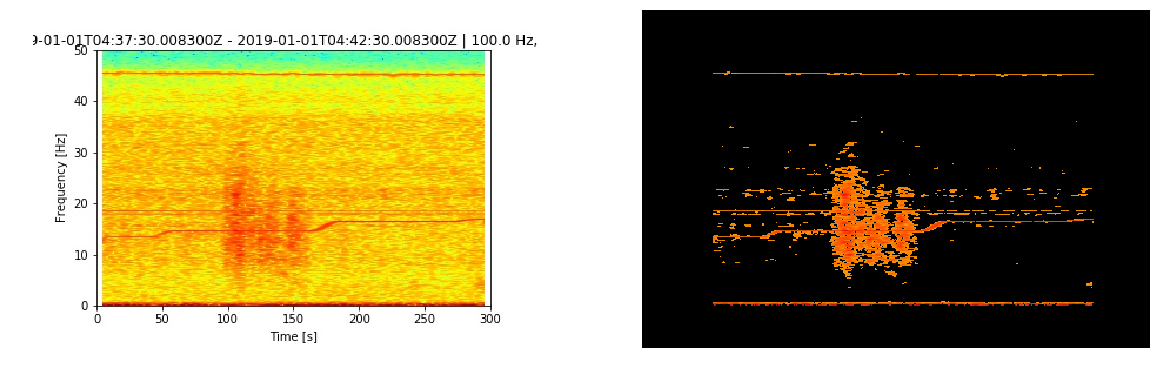

In [39]:
#Reads image, converts it back to RGB, Displays It
im = cv2.imread("data/ABC/spectrograms/2019001/" + "04_37_30_sig.jpg")
RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.axis('off')
ax1.imshow(RGB_img)

#Set RGB Bounds for what we want to filter
lower_red = np.array([180,0,0])
upper_red = np.array([255,150,30])

#Create the mask
mask = cv2.inRange(RGB_img, lower_red, upper_red)
res = cv2.bitwise_and(RGB_img,RGB_img, mask= mask)

#Visualize
ax2.axis('off')
ax2.imshow(res)

#### Insights:
- Doesn't really focus in on just the line
- RGB Values Vary Across different samples because of different intensity (inconsistent!)
- What's intense in one spectogram **may not be intense in another**

### Attempt Number Two: Convolutions
#### What if we tried to look at the greatest differences in RGB Values? AKA Edges!

In [41]:
#Creating a list of visuals
day3 = (listdir("data/ABC/spectrograms/2019003"))
sig_list = [x for x in day3 if 'sig' in x]
sig_list = sorted(sig_list)
sig_list = sig_list[1:]

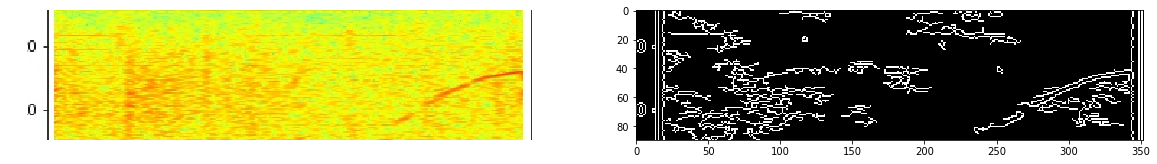

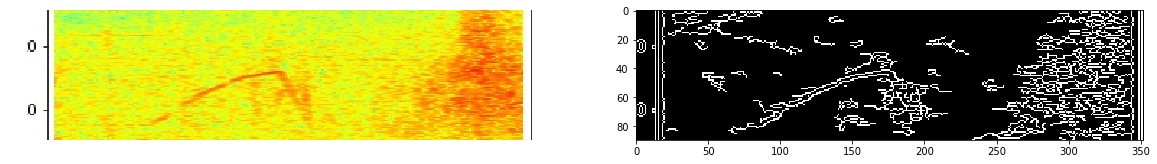

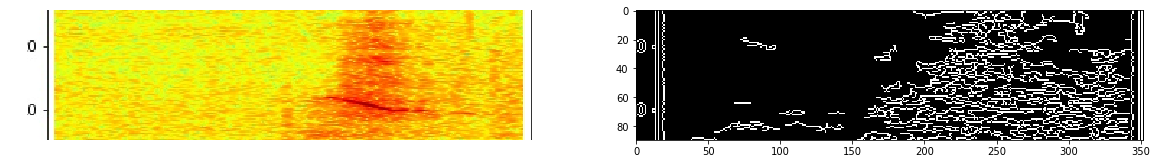

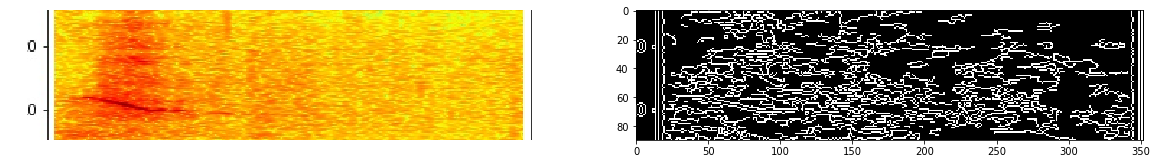

In [42]:
for i in range(4):
    #show normal version
    im = cv2.imread("data/ABC/spectrograms/2019003/" + sig_list[i])
    RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #only displaying region with phase shifts (10 - 20 Hertz)
    RGB_img = RGB_img[140:230, 40:-40, :]
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
    ax1.axis('off')
    ax1.imshow(RGB_img)
    
    #show convolution version
    res = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    res = res[140:230, 40:-40, :]
    plt.rc('image', cmap='gray')
    display = cv2.Canny(res, 90, 300)
    ax2.imshow(display)

#### Insights:
- Absolute mess -- edges are being detected everywhere 
- We need a way to only look for the most significant edges
- Let's blur the image a little bit before analyzing it

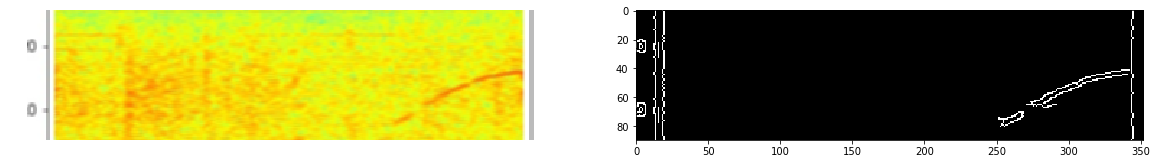

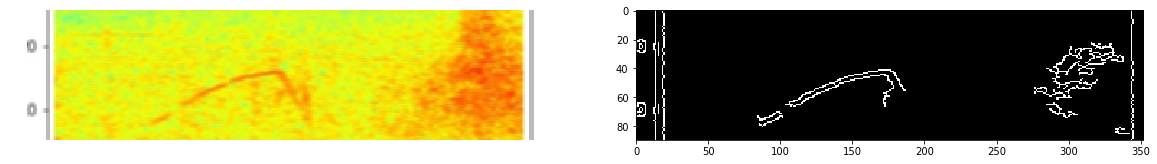

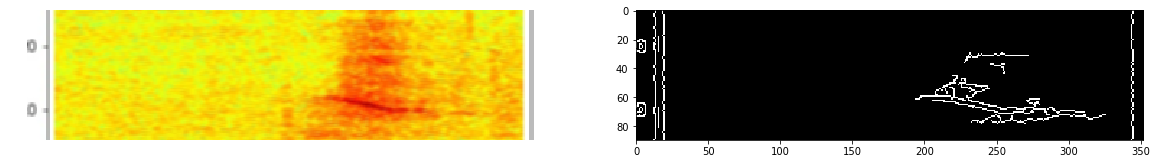

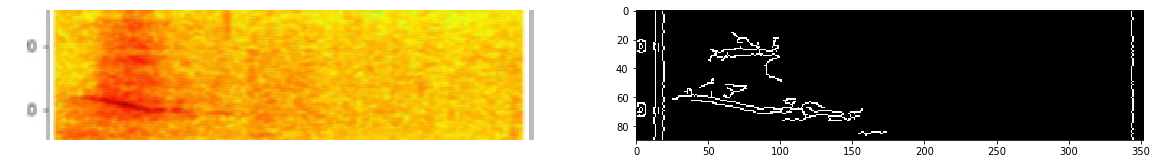

In [45]:
for i in range(4):
    #show normal version
    im = cv2.imread("data/ABC/spectrograms/2019003/" + sig_list[i])
    RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #only displaying region with phase shifts (10 - 20 Hertz)
    #Apply a normal blur
    img = cv2.blur(RGB_img,(3,3))
    img = img[140:230, 40:-40, :]
    #find edges
    display = cv2.Canny(img, 90, 300)
    #Plot
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
    ax1.axis('off')
    ax1.imshow(img)
    plt.rc('image', cmap='gray')
    ax2.imshow(display)

#### Insights:
- Almost there -- too many vertical values being selected 
- Let's apply a rectangular kernel to blur with the purpose of maintaining horizontal continuity

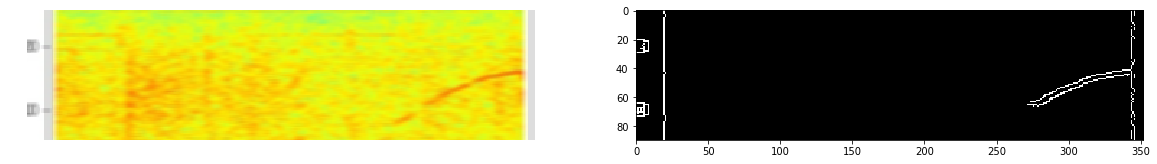

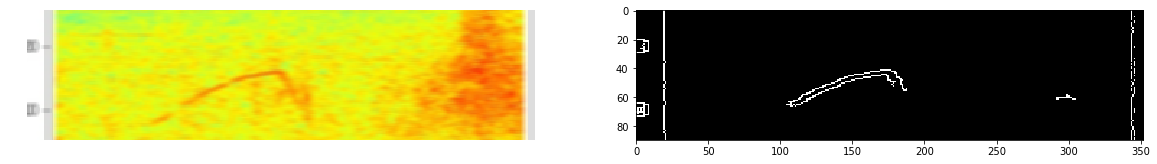

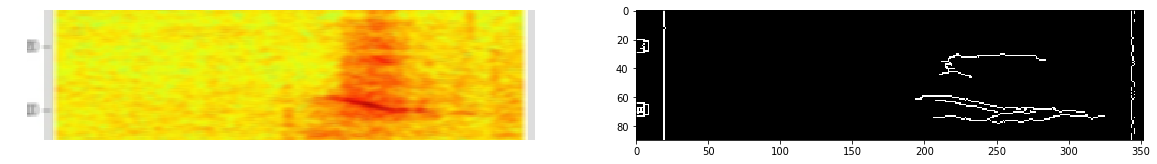

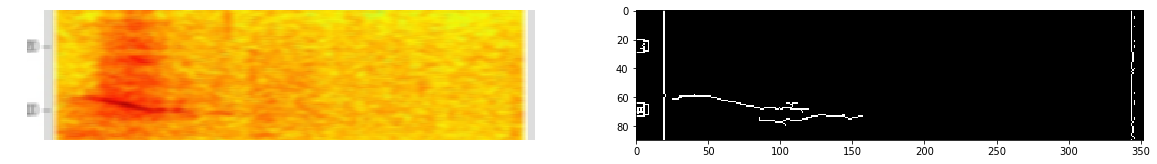

In [49]:
for i in range(4):
    #show normal version
    im = cv2.imread("data/ABC/spectrograms/2019003/" + sig_list[i])
    RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #only displaying region with phase shifts (10 - 20 Hertz)
    #Apply a normal blur
    img = cv2.blur(RGB_img,(6,3))
    img = img[140:230, 40:-40, :]
    #find edges
    display = cv2.Canny(img, 90, 300)
    #Plot
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
    ax1.axis('off')
    ax1.imshow(img)
    plt.rc('image', cmap='gray')
    ax2.imshow(display)

### So who cares? Why does being able to do this matter?
##### It's now super easy to use image segmentation to identify the phase shifts & give us their width & height
##### This allows us to collect event duration and frequency automatically!

## Boundary Identification with Image Segmentation
#### Now that we've created lines replicating the phase shifts, how can we extract meaningful data from the results?
##### We find bounding boxes to extract the freqency bands and the time durations

In [46]:
day3 = (listdir("data/ABC/spectrograms/2019003"))
day3 = sorted(day3)
day3 = day3[6:]

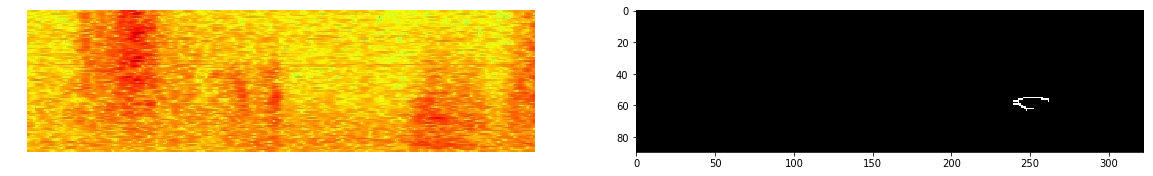

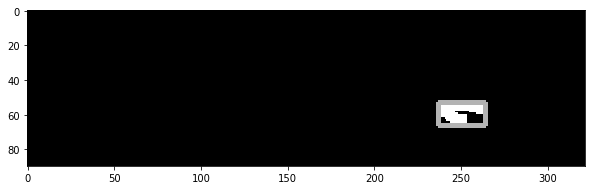

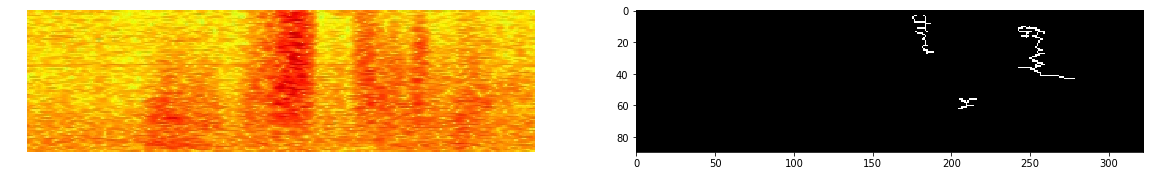

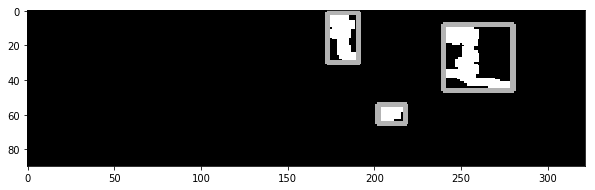

In [51]:
for i in range(0,2):
    #show normal version
    file = day3[i]
    filename = "data/ABC/spectrograms/2019003/" + file
    im = cv2.imread(filename)
    RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
    ax1.axis('off')
    RGB_img = RGB_img[140:230, 60:-50, :] 
    ax1.imshow(RGB_img)
    #fixes open cv BGR initialization
    res = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   
    res = res[140:230, 60:-50, :]    
    #stops matplotlib from making odd color schemes
    plt.rc('image', cmap='gray')
    res = cv2.blur(res,(6,3))
    #Creates canny edges
    display = cv2.Canny(res, 90, 300)
    ax2.imshow(display)
    mask = cv2.inRange(display, 100, 255)
    kernel = np.ones((5, 5), np.uint8)
    # Erode / dilate to make label appear "boxy"
    boxy = cv2.erode(mask, kernel, iterations=0)
    boxy = cv2.dilate(boxy, kernel, iterations=1)
    
    ##Create the boxes
    contours, _ = cv2.findContours(boxy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(im, contour, -1, (0, 255, 0), 3)
        boundRect = cv2.boundingRect(contour)
        color = (180, 180, 180)
        cv2.rectangle(boxy, (int(boundRect[0]), int(boundRect[1])), 
        (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), color, 2)
        cv2.rectangle(RGB_img, (int(boundRect[0]), int(boundRect[1])), 
        (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), color, 2)
    
        width = boundRect[2]
        height= boundRect[3]
    plt.rcParams["figure.figsize"] = (10,5)
    plt.figure()
    plt.imshow(boxy)

#### Any decent examples?

<img src="Images/Example1.png">
<img style="width: 600px" src="Images/Example1Box.png">
<img src="Images/Example2.png">
<img style="width: 600px" src="Images/Example2Box.png">
<img src="Images/Example3.png">
<img style="width: 600px" src="Images/BoxExample3.png">

### Let's use the position of the edges to learn more about the duration and frequency of the seismic events

In [86]:
#Converts the pixel values in our slice to frequencies based on the scale
def intToFrequency(number, bottom_frequency, top_frequency, max_value):
    difference = top_frequency - bottom_frequency
    percentage = number / max_value
    return round(top_frequency - percentage * difference - 2, 2)

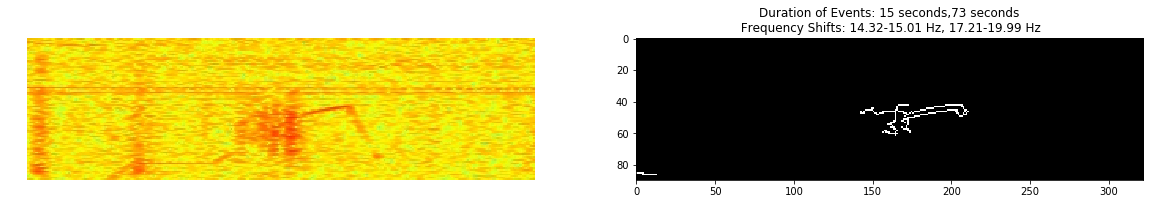

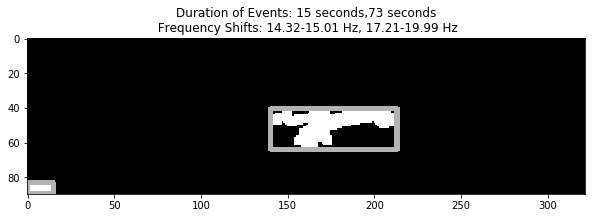

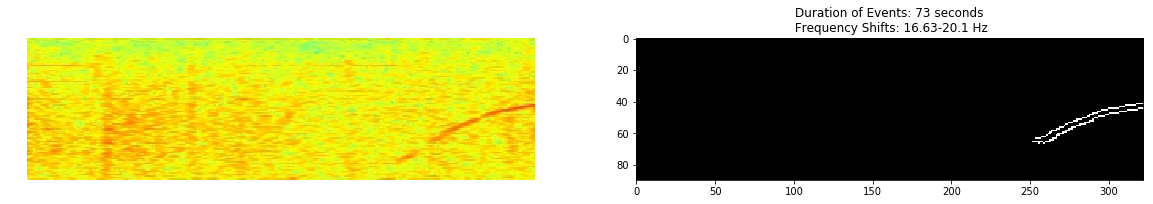

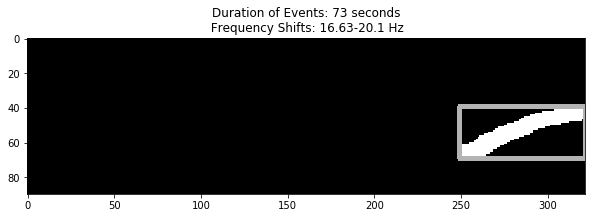

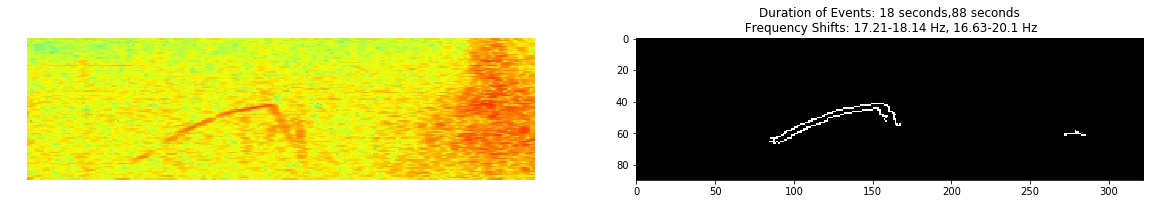

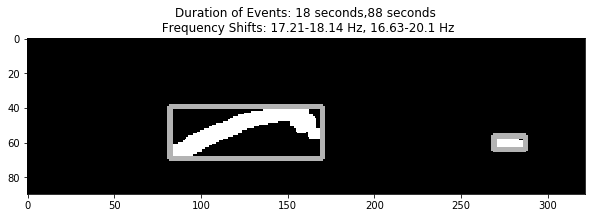

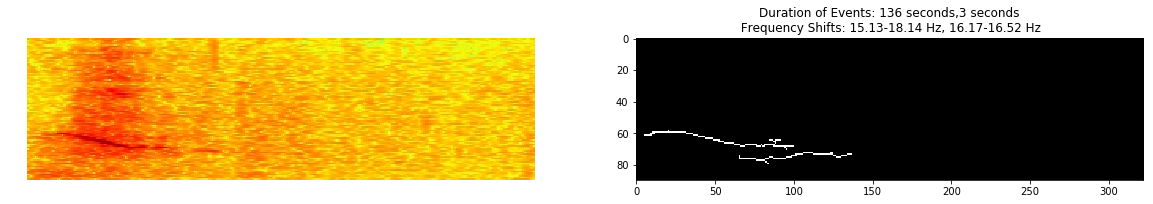

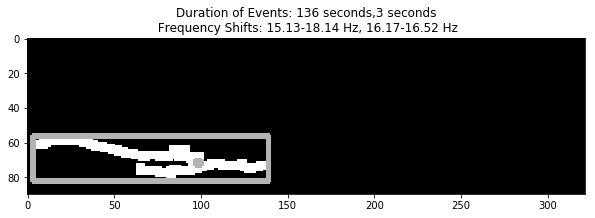

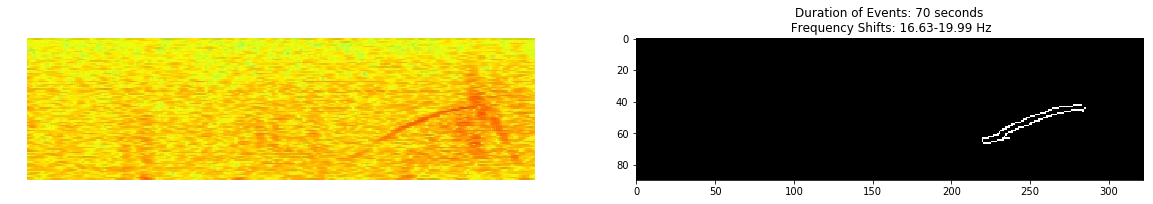

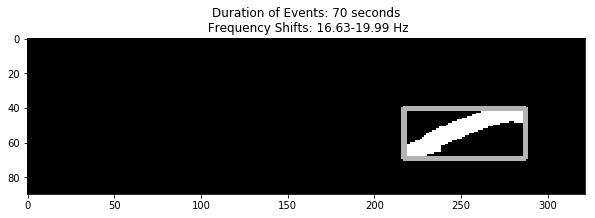

In [101]:
special_index = [10, 15, 16, 20, 21]
for i in special_index:
    #show normal version
    file = day3[i]
    filename = "data/ABC/spectrograms/2019003/" + file
    im = cv2.imread(filename)
    RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
    ax1.axis('off')
    RGB_img = RGB_img[140:230, 60:-50, :] 
    ax1.imshow(RGB_img)
    #fixes opencv BGR initialization
    res = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   
    res = res[140:230, 60:-50, :]    
    #stops matplotlib from converting color schemes
    plt.rc('image', cmap='gray')
    res = cv2.blur(res,(6,3))
    #Creates canny edges
    display = cv2.Canny(res, 90, 300)
    ax2.imshow(display)
    mask = cv2.inRange(display, 100, 255)
    kernel = np.ones((5, 5), np.uint8)
    # Erode / dilate to make label appear "boxy"
    boxy = cv2.erode(mask, kernel, iterations=0)
    boxy = cv2.dilate(boxy, kernel, iterations=1)
    
    ##Create the boxes
    contours, _ = cv2.findContours(boxy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    width_list = []
    frequency_list = []
    for contour in contours:
        cv2.drawContours(im, contour, -1, (0, 255, 0), 3)
        boundRect = cv2.boundingRect(contour)
        color = (180, 180, 180)
        cv2.rectangle(boxy, (int(boundRect[0]), int(boundRect[1])), 
        (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), color, 2)
        cv2.rectangle(RGB_img, (int(boundRect[0]), int(boundRect[1])), 
        (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), color, 2)
        
        width = boundRect[2]
        height= boundRect[3]
        highFreq = intToFrequency(boundRect[1], 16.2, 26.62, 90)
        lowFreq = intToFrequency((boundRect[1] + height), 16.2, 26.62, 90)
        frequency_list.append(str(lowFreq) + "-" + str(highFreq) + " Hz")
        width_list.append(width)
    width_list = [str(i) + " seconds" for i in width_list]
    plt.title("Duration of Events: " + ",".join(width_list) + "\n Frequency Shifts: " + ", ".join(frequency_list))
    plt.rcParams["figure.figsize"] = (10,5)
    plt.figure()
    plt.title("Duration of Events: " + ",".join(width_list) + "\n Frequency Shifts: " + ", ".join(frequency_list))
    plt.imshow(boxy)

### We also want to find TYPES of events. To do this, cluster  the processed spectrograms
# See FinalClustering.ipynb

We have now filtered out the up-and-down shifts. Next, we categorize anomalies into groups/classes using a deep/unsupervised learning/ hybrid approach.  
To do this, we take a clustering approach that leverages a Deep Neural Network (DNN), kMeans clustering, and result tuning using object detection.  

- Applied a ResNet model to each image to compute a feature vector
- Filtered for non-event data 
- Trained a clusterer and extracted labels for each image
- 5 total clusters found: 
    - Seemingly long/wide bands, long/tall bands, sparse short bursts, and multiple short bursts 


### Let's run these statistics for all images available to us

In [97]:
images = [x for x in listdir("editSpectograms") if ".jpg" in x]

In [152]:
df = pd.DataFrame(columns=["File Name", "Number of Events", "Duration of Events", "Frequency Change of Events"])
for image in images:
    filename = "editSpectograms/" + image
    im = cv2.imread(filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.blur(im,(6,3))
    im = cv2.Canny(im, 90, 300)
    mask = cv2.inRange(im, 100, 255)
    kernel = np.ones((5, 5), np.uint8)
    # Erode / dilate to make label appear "boxy"
    boxy = cv2.erode(mask, kernel, iterations=0)
    boxy = cv2.dilate(boxy, kernel, iterations=1)
    ##Create the boxes
    contours, _ = cv2.findContours(boxy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    width_list = []
    frequency_list = []
    for contour in contours:
        cv2.drawContours(im, contour, -1, (0, 255, 0), 3)
        boundRect = cv2.boundingRect(contour)
        color = (180, 180, 180)
        cv2.rectangle(boxy, (int(boundRect[0]), int(boundRect[1])), 
        (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), color, 2)
        cv2.rectangle(im, (int(boundRect[0]), int(boundRect[1])), 
        (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), color, 2)
        
        width = boundRect[2]
        height= boundRect[3]
        highFreq = intToFrequency(boundRect[1], 16.2, 26.62, 90)
        lowFreq = intToFrequency((boundRect[1] + height), 16.2, 26.62, 90)
        frequency_list.append(str(lowFreq) + "-" + str(highFreq) + " Hz")
        width_list.append(width)
    elements = len(width_list)
    s2 = pd.Series([image, elements, width_list, frequency_list], index=['File Name', 'Number of Events', 'Duration of Events', 'Frequency Change of Events'])
    df = df.append(s2, ignore_index=True)

## Now we want all of our data in one place. Houston, we have a dataframe!

In [153]:
df.head()

,File Name,Number of Events,Duration of Events,Frequency Change of Events
0,e_1_18_57_30.jpg,6,"[32, 38, 26, 5, 35, 40]","[15.82-17.33 Hz, 15.82-17.56 Hz, 17.09-18.37 H..."
1,e_6_17_17_30.jpg,0,[],[]
2,e_2_21_35_00.jpg,0,[],[]
3,e_4_01_35_00.jpg,1,[126],[18.83-20.8 Hz]
4,e_3_00_40_00.jpg,0,[],[]


### Let's create a visualization to better understand event duration

In [154]:
event_durations = []
for index, row in df.iterrows():
    test_slice = df.iloc[index]["Duration of Events"]
    for i in test_slice:
        event_durations.append(i)

Text(0.5, 0, 'Duration of Shift (in Seconds)')

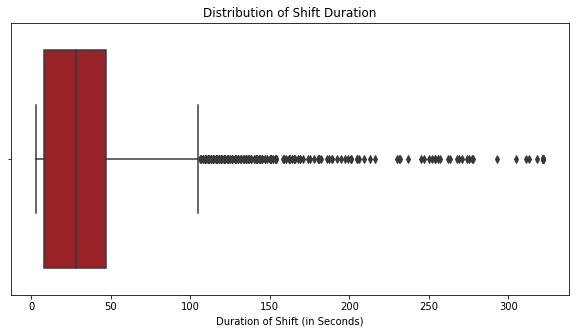

In [188]:
sns.set_palette((sns.color_palette("Reds_r")))
sns.boxplot(event_durations)
plt.title("Distribution of Shift Duration")
plt.xlabel("Duration of Shift (in Seconds)")

### Can we do anything useful with frequency?

In [159]:
df["Net Changes per Element"] = ""

In [160]:
for index, row in df.iterrows():
    test_slice = df.iloc[index]["Frequency Change of Events"]
    change_values = []
    for i in test_slice:
        values = i.split("-")
        bottom = float(values[0])
        top = float(values[1][:-3])
        change_values.append((round(top - bottom,2)))
    df.iloc[index]["Net Changes per Element"] = change_values

In [161]:
df.head()

,File Name,Number of Events,Duration of Events,Frequency Change of Events,Net Changes per Element
0,e_1_18_57_30.jpg,6,"[32, 38, 26, 5, 35, 40]","[15.82-17.33 Hz, 15.82-17.56 Hz, 17.09-18.37 H...","[1.51, 1.74, 1.28, 0.34, 1.28, 2.09]"
1,e_6_17_17_30.jpg,0,[],[],[]
2,e_2_21_35_00.jpg,0,[],[],[]
3,e_4_01_35_00.jpg,1,[126],[18.83-20.8 Hz],[1.97]
4,e_3_00_40_00.jpg,0,[],[],[]


In [162]:
frequency_shifts = []
for index, row in df.iterrows():
    test_slice = df.iloc[index]["Net Changes per Element"]
    for i in test_slice:
        frequency_shifts.append(i)

Text(0.5, 0, 'Magnitude of Change in Hertz')

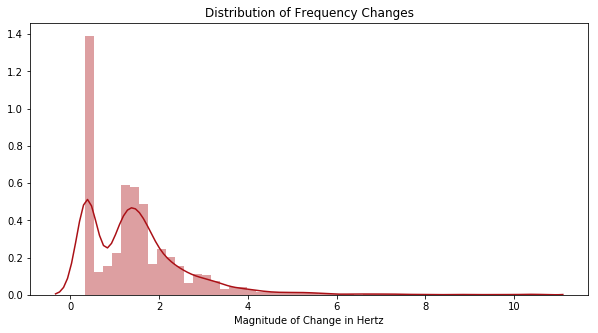

In [191]:
sns.distplot(frequency_shifts)
plt.title("Distribution of Frequency Changes")
plt.xlabel("Magnitude of Change in Hertz")

## Constraints and Improvements
#### How We Can Improve & Why We Should -- Notes for Implementation

- Failed to consider signage of the frequency shifts
- Don't slice images as severely -- missing out on low frequency shifts
- Further process spectograms & apply more thorough filters prior to parsing data from images

--------------------------------------------------------------
<center><h1>Thanks So Much For Your Time!</h1></center><br>
<img style="width: 200px" src="Images/question.jpg">
<center><h2>Any Questions?</h2></center>